In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [5]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [6]:
# Define the data directory
data_dir = 'dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 247, 'val': 112}


['crease', 'damage', 'dot', 'scratch']

In [8]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Training loop
num_epochs = 35
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


train Loss: 2.7398 Acc: 0.4453
val Loss: 1.0944 Acc: 0.6429
train Loss: 0.9812 Acc: 0.6721
val Loss: 1.0602 Acc: 0.6339
train Loss: 0.8322 Acc: 0.6842
val Loss: 0.7432 Acc: 0.7321
train Loss: 0.8612 Acc: 0.6802
val Loss: 0.7918 Acc: 0.7589
train Loss: 0.9448 Acc: 0.6599
val Loss: 0.5487 Acc: 0.8214
train Loss: 0.8423 Acc: 0.6964
val Loss: 0.4747 Acc: 0.8571
train Loss: 0.6973 Acc: 0.7126
val Loss: 0.5007 Acc: 0.8125
train Loss: 0.9319 Acc: 0.6397
val Loss: 1.0769 Acc: 0.6429
train Loss: 0.7752 Acc: 0.6883
val Loss: 0.4539 Acc: 0.8482
train Loss: 0.7033 Acc: 0.7611
val Loss: 0.4809 Acc: 0.8393
train Loss: 0.7326 Acc: 0.7045
val Loss: 0.5924 Acc: 0.7768
train Loss: 0.7553 Acc: 0.6923
val Loss: 0.3630 Acc: 0.8482
train Loss: 0.7693 Acc: 0.7287
val Loss: 0.5394 Acc: 0.8036
train Loss: 0.8525 Acc: 0.6964
val Loss: 0.3416 Acc: 0.8571
train Loss: 0.8364 Acc: 0.7045
val Loss: 0.4115 Acc: 0.8482
train Loss: 0.7218 Acc: 0.7449
val Loss: 0.3662 Acc: 0.8214
train Loss: 0.7115 Acc: 0.7328
val Loss:

In [10]:

# Save the model
torch.save(model.state_dict(), 'resnet.pth')


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference. 

In [11]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('resnet.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24144\394956563.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet.pth'))


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [16]:
# Load and preprocess the unseen image
image_path = 'Aero-engine_defect-detect_new/images/train/10.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Perform inference using the model:

In [19]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['crease', 'damage', 'dot', 'scratch']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: damage


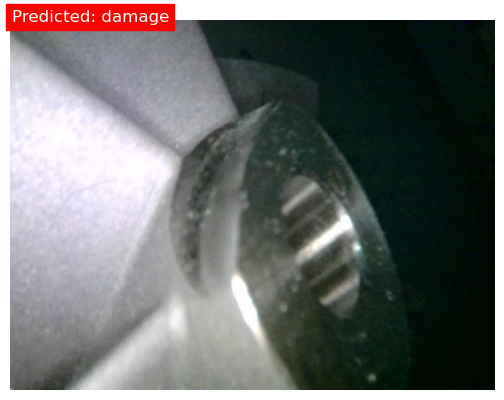

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()